## Demo target data generator

This notebook shows how to use the target data generator to supply training data to use when fitting the PDF model. The `target_data_generator` implemented in `fit_target_data_model.py` yields an infinite stream of target data, by randomly generating new arrays of $p_{50\%}$ and $\log_{10}M_{\rm p},$ and computing the mean and variance of the input concentrations across time.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines

### Load the simulation data that includes best-fitting diffprof parameters

In [3]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


### Calculate ${\rm conc}(t_{\rm fit})$ based on the diffprof parameters

In [4]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(2, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


### Calculate downsampling masks

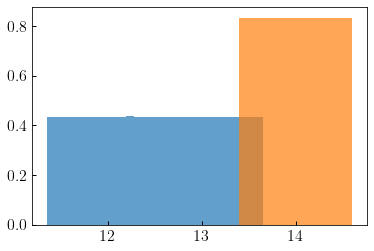

In [5]:
from diffprof.latin_hypercube_sampler import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

fig, ax = plt.subplots(1, 1)
__=ax.hist(bpl['logmp'][indx_bpl], bins=30, density=True, alpha=0.7)
__=ax.hist(mdpl2['logmp'][indx_mdpl2], bins=30, density=True, alpha=0.7)


### Calculate the target data generator for this downsample of halos



In [6]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 20, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS
       )
gen = target_data_generator(*args)

### Plot average concentration vs. mass

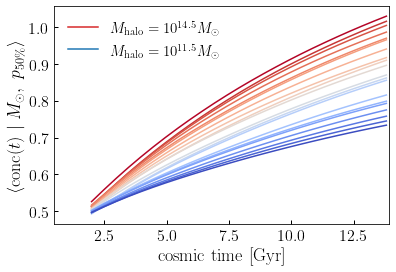

In [7]:
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]

lgm_colors=cm.coolwarm(np.linspace(1,0,N_MH_TARGETS))
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')
for im in range(N_MH_TARGETS):
    __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0[im, :], color=lgm_colors[im])

    
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11.5}M_{\odot}$')
leg=ax.legend(handles=[red_line, blue_line])

fig.savefig('mean_lgm0_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

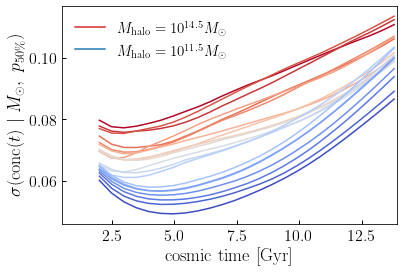

In [8]:
lgm_colors=cm.coolwarm(np.linspace(1,0,N_MH_TARGETS))
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

for im in range(N_MH_TARGETS):
    __=ax.plot(TARR_FIT, lgc_std_targets_lgm0[im, :], color=lgm_colors[im])
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11.5}M_{\odot}$')
leg=ax.legend(handles=[red_line, blue_line])
fig.savefig('std_lgm0_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

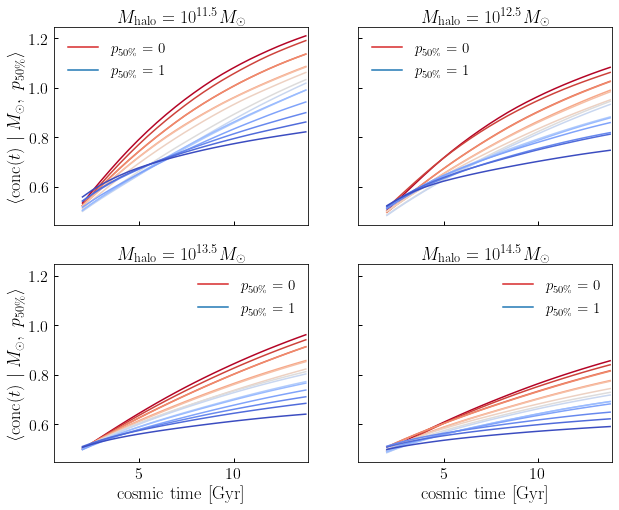

In [9]:
p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
# fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(0.5, 13.9)
axes = ax0, ax1, ax2, ax3

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
    

for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')
        

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')
for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])
    leg=ax.legend(handles=[red_line, blue_line])

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)
fig.savefig('mean_p50_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

Runtime to generate target data = 5.2 seconds


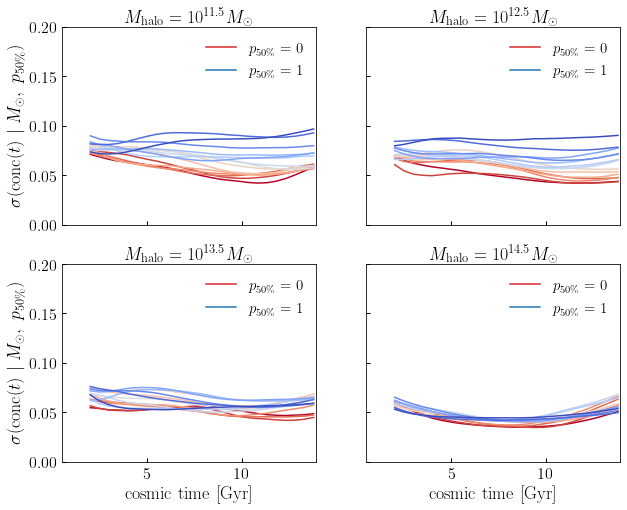

In [10]:
start = time()
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]
end = time()
print("Runtime to generate target data = {0:.1f} seconds".format(end-start))

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
xlim = ax0.set_xlim(0.5, 13.9)
ylim = ax0.set_ylim(0, 0.2)
axes = ax0, ax1, ax2, ax3

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')

for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_std_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])
    leg=ax.legend(handles=[red_line, blue_line])

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)
fig.savefig('std_p50_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

## Now build a simple toy model for $\sigma({\rm conc}(t)\ \vert\ M_{\odot}, p_{50\%})$

The goal is simply to roughly capture the curves in the previous plot using a simple, smooth parametric model.

When I inspect those curves, what I see are three basic things:
1. There's not a lot of time-dependence, especially for $t\gtrsim2.5\ {\rm Gyr},$ so we can probably assume time-independent scatter.
2. For halos with $p_{50\%}$ of all mass, the scatter looks about constant of 0.05 dex
3. For lower-mass halos, there is a $p_{50\%}$-dependent _width_ in the scatter that is roughly 0.04 dex, and this width practically vanishes in cluster-mass halos. 

So let's first focus on (3) and build a simple model for the width function, $W(m),$ where I'm writing $m\equiv\log_{10}M_{\rm h}$ for notational convenience. To get us started, let's try out a sigmoid function for the shape of $W(m).$ To make the plot below, I just fiddled for a minute with the 4 sigmoid parameters until I got a curve that looks about right.

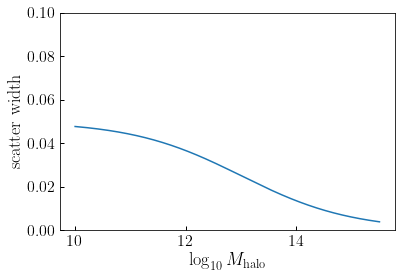

In [11]:
@jjit
def _sigmoid(x, x0, k, ylo, yhi):
    height_diff = yhi - ylo
    return ylo + height_diff / (1 + jnp.exp(-k * (x - x0)))

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 0.1)

lgmarr = np.linspace(10, 15.5, 500)
delta_scatter_p50 = _sigmoid(lgmarr, 13, 1, 0.05, 0)
__=ax.plot(lgmarr, delta_scatter_p50)
xlabel = ax.set_xlabel(r'$\log_{10}M_{\rm halo}$')
xlabel = ax.set_ylabel(r'${\rm scatter\ width}$')


Ok, now that we have our rough sigmoid-type behavior to the width of the scatter, let's port that into a callable function.

In [12]:
@jjit
def _scatter_p50_width_vs_lgmhalo(
    lgmh, p50_sig_width_x0=13, p50_sig_width_k=1, p50_sig_width_ylo=0.05, p50_sig_width_yhi=0):
    return _sigmoid(lgmh, p50_sig_width_x0, p50_sig_width_k, p50_sig_width_ylo, p50_sig_width_yhi)

Now that we have our model for the width, then we can use this model together with observation (1) to build a simple model for the value of the scatter, $\sigma(p, m).$ So we want to write down some function that returns $\sigma(p\rightarrow0, m)\approx0.05,$ and also $\sigma(p\rightarrow1, m)\approx0.05+W(m),$ where the $W(m)$ is the width function we calibrated above. To implement such a function for $\sigma(p, m),$ what functional form should we use? Let's try...you guessed it, a sigmoid function!

The last ingredient we need is just to know how to set our value of $k$ for how rapidly the sigmoid function will transition the scatter from its lower-bound value of $\sigma\approx0.05$ to its upper value of $\sigma\approx0.05+W(m).$ In the figure below, I show that $k\approx5$ is about right.

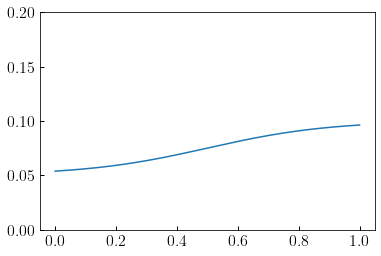

In [13]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 0.2)
pp = np.linspace(0, 1, 500)

sig_lo, sig_hi = 0.05, 0.1
k_p = 5
__=ax.plot(pp, _sigmoid(pp, 0.5, k_p, sig_lo, sig_hi))

In [14]:
@jjit
def _scatter_vs_p50_and_lgmhalo(
    lgmh, p, p_lo=0.05, p50_sig_width_x0=13, p50_sig_width_k=1, 
    p50_sig_width_ylo=0.05, p50_sig_width_yhi=0):
    width = _scatter_p50_width_vs_lgmhalo(
        lgmh, p50_sig_width_x0, p50_sig_width_k, 
        p50_sig_width_ylo, p50_sig_width_yhi)
    
    return _sigmoid(p, 0.5, 5, p_lo, p_lo+width)

Now let's make our 4-panel plot of $\sigma(p, m)$ and overplot our new simple model.

Runtime to generate target data = 5.6 seconds


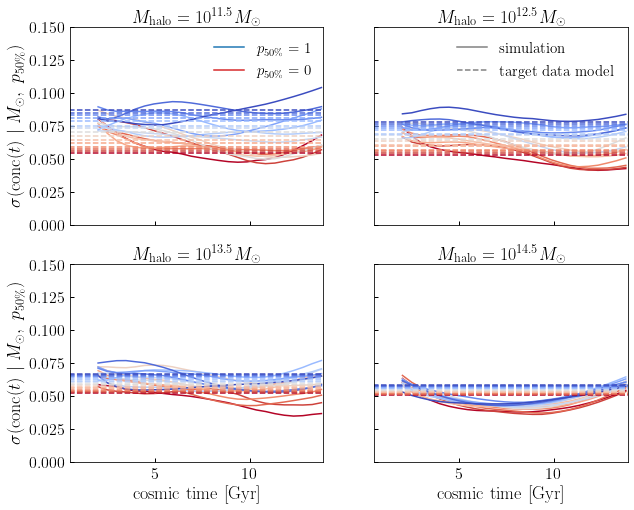

In [15]:
start = time()
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]
end = time()
print("Runtime to generate target data = {0:.1f} seconds".format(end-start))

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
xlim = ax0.set_xlim(0.5, 13.9)
ylim = ax0.set_ylim(0, 0.15)
axes = ax0, ax1, ax2, ax3

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')

for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_std_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)

tarr_plot = np.linspace(-100, 100, 5000)
for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    for ip, p50 in enumerate(p50_targets):
        scatter = _scatter_vs_p50_and_lgmhalo(lgm, p50)
        __=ax.plot(tarr_plot, np.zeros_like(tarr_plot)+scatter, '--', color=p50_colors[ip])

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')
solid_line=mlines.Line2D([],[],ls='-',c='gray',label=r'${\rm simulation}$')
dashed_line=mlines.Line2D([],[],ls='--',c='gray',label=r'${\rm target\ data\ model}$')

leg=ax0.legend(handles=[blue_line, red_line])
leg=ax1.legend(handles=[solid_line, dashed_line])

fig.savefig('std_p50_target_data_model_demo.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

### Not bad! 

All the basic trends are captured, and our function $\sigma(m, p, t)$ is relatively simple. Looking at this last plot, we could probably improve on it slightly if we had set our lower bound to something more like $0.04,$ and maybe the width should be slightly larger in lower-mass halos as well. So the final step towards building this target data model is just to optimize the parameters we used to define $\sigma(m, p, t).$ To do that, these functions should be ported into a module, you'll need to implement them such that the relevant parameters are not just hard-coded default values, and instead are allowed to vary freely. Then you'll need to define an MSE loss function that calculates the difference between some input targets and the model predictions, and this is the MSE loss that you'll use with the usual `jax_adam_wrapper` function. For the targets, you can get them using the same `target_data_generator` used to make this plot. And just like you have been doing with the actual `diffprof` model, you should write a simple for loop where you generate some target data, to gradient descent on the parameters for ~100 steps, then generate a new variation on the target data, burn for another ~100 steps, and proceed until your model parameters settle into something that gives a good description for what we see in this plot. Probably the best-fit parameters will not be too far off from the default values in this notebook.

Once that is done, then you can return to optimizing the actual `diffprof` model, and instead of using the `target_data_generator`, you can use the newly-developed target data model.